<a href="https://colab.research.google.com/github/cerysojj/micaflow/blob/main/toybox_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import libraries and define MLP class

In [ ]:
#Pytorch Implementation of a 2 Layer MLP
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import os

In [ ]:
class MLP_1layer(nn.Module):
  def __init__(self, input_size=20736, num_classes=13, layer=2048):
    super(MLP_1layer, self).__init__()
    self.d1 = nn.Linear(input_size, layer)
    self.d2 = nn.Linear(layer, num_classes)

  def forward(self, x):
    x = F.relu(self.d1(x))
    x = F.log_softmax(self.d2(x), dim=1)
    return x

In [ ]:
class MLP_2layer(nn.Module):
  def __init__(self, input_size=20736, num_classes=13, layers=[2048, 1024]):
    super(MLP_2layer, self).__init__()
    self.d1 = nn.Linear(input_size, layers[0])
    self.d2 = nn.Linear(layers[0], layers[1])
    self.d3 = nn.Linear(layers[1], num_classes)

  def forward(self, x):
    x = F.relu(self.d1(x))
    x = F.relu(self.d2(x))
    x = F.log_softmax(self.d3(x), dim=1)
    return x

In [ ]:
class MLP_3layer(nn.Module):
  def __init__(self, input_size=20736, num_classes=13, layers=[2048, 1024, 512]):
    super(MLP_3layer, self).__init__()
    self.d1 = nn.Linear(input_size, layers[0])
    self.d2 = nn.Linear(layers[0], layers[1])
    self.d3 = nn.Linear(layers[1], layers[2])
    self.d4 = nn.Linear(layers[2], num_classes)

  def forward(self, x):
    x = F.relu(self.d1(x))
    x = F.relu(self.d2(x))
    x = F.relu(self.d3(x))
    x = F.log_softmax(self.d4(x), dim=1)
    return x

In [ ]:
def plot_confusion_matrices(train_labels, train_preds, val_labels, val_preds, num_layers):
    """
    Plots confusion matrices for training and validation datasets.

    Parameters:
    - train_labels: True labels for the training dataset.
    - train_preds: Predicted labels for the training dataset.
    - val_labels: True labels for the validation dataset.
    - val_preds: Predicted labels for the validation dataset.
    """
    # Convert lists to numpy arrays if they're not already
    train_labels = np.array(train_labels)
    train_preds = np.array(train_preds)
    val_labels = np.array(val_labels)
    val_preds = np.array(val_preds)

    # Create confusion matrix for training data
    cm_train = confusion_matrix(train_labels, train_preds)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)

    # Create confusion matrix for validation data
    cm_val = confusion_matrix(val_labels, val_preds)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)

    # Set up the plotting area
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot confusion matrix for training data
    disp_train.plot(ax=axs[0], cmap=plt.cm.Blues, im_kw={'interpolation': 'nearest'})
    axs[0].set_title(f'Training Confusion Matrix for {num_layers}-layer MLP', fontsize=16)
    axs[0].set_xlabel('Predicted Label', fontsize=14)
    axs[0].set_ylabel('True Label', fontsize=14)

    # Plot confusion matrix for validation data
    disp_val.plot(ax=axs[1], cmap=plt.cm.Blues, im_kw={'interpolation': 'nearest'})
    axs[1].set_title(f'Validation Confusion Matrix for {num_layers}-layer MLP', fontsize=16)
    axs[1].set_xlabel('Predicted Label', fontsize=14)
    axs[1].set_ylabel('True Label', fontsize=14)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_average_metrics(all_train_losses, all_val_losses, all_train_correct, all_val_correct,
                         hyperparameters, num_layers):
    """
    Plots average training and validation loss and accuracy across folds.

    Parameters:
    - all_train_losses: List of training losses from each fold.
    - all_val_losses: List of validation losses from each fold.
    - all_train_correct: List of correct training predictions from each fold.
    - all_val_correct: List of correct validation predictions from each fold.
    - hyperparameters: Dictionary of hyperparameters used in the model.
    - num_layers: Number of layers in the model (for labeling purposes).
    """
    # Calculate average metrics across folds
    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_val_losses = np.mean(all_val_losses, axis=0)
    avg_train_accuracy = np.mean([np.array(correct) / len(all_train_correct[0]) for correct in all_train_correct], axis=0)
    avg_val_accuracy = np.mean([np.array(correct) / len(all_val_correct[0]) for correct in all_val_correct], axis=0)

    plt.figure(figsize=(12, 6))

    # Plot loss metrics
    plt.subplot(2, 1, 1)
    plt.plot(avg_train_losses, color='teal', label='Avg Train Loss')
    plt.plot(avg_val_losses, color='orange', label='Avg Val Loss')
    plt.title(f'Averaged Loss Across Folds for {num_layers}-layer MLP')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot averaged accuracy metrics
    plt.subplot(2, 1, 2)
    plt.plot(avg_train_accuracy, color='teal', label='Avg Train Accuracy')
    plt.plot(avg_val_accuracy, color='orange', label='Avg Val Accuracy')
    plt.title(f'Averaged Accuracy Across Folds for {num_layers}-layer MLP')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Display hyperparameters
    hyperparam_text = '\n'.join([f'{key}: {value}' for key, value in hyperparameters.items()])
    plt.gcf().text(0.85, 0.5, f'Hyperparameters:\n{hyperparam_text}', fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.5), verticalalignment='center')

    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    plt.show()

# Download Toybox Dataset

### Saving original datasets (animals, households, vehicles) to google drive

In [ ]:
import requests
import os
from google.colab import drive

drive.mount('/content/drive')

# Save animals data to google drive
save_path = '/content/drive/My Drive/animals.tar.gz'

if not os.path.exists(save_path):
    animals = "https://zenodo.org/records/1289936/files/animals.tar.gz?download=1"
    response = requests.get(animals, stream=True)

    with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("File downloaded and saved to Google Drive")
else:
    print("File already exists in Google Drive")

Mounted at /content/drive
File already exists in Google Drive


In [ ]:
# Save households data to google drive
save_path = '/content/drive/MyDrive/households.tar.gz'

if not os.path.exists(save_path):
    households = "https://zenodo.org/records/1290019/files/households.tar.gz?download=1"
    response = requests.get(households, stream=True)

    with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("File downloaded and saved to Google Drive")
else:
    print("File already exists in Google Drive")

File already exists in Google Drive


In [ ]:
# Save vehicles data to google drive
save_path = '/content/drive/MyDrive/vehicles.tar.gz'

if not os.path.exists(save_path):
  vehicles = "https://zenodo.org/records/1290757/files/vehicles.tar.gz?download=1"
  response = requests.get(vehicles, stream=True)

  with open(save_path, "wb") as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
  print("File downloaded and saved to Google Drive")
else:
    print("File already exists in Google Drive")

File downloaded and saved to Google Drive


### Extract the files from datasets saved on Google Drive

In [ ]:
households = '/content/drive/MyDrive/households.tar.gz'
animals = '/content/drive/MyDrive/animals.tar.gz'
vehicles = '/content/drive/MyDrive/vehicles.tar.gz'

In [ ]:
import tarfile

for file in [households, animals, vehicles]:
  if tarfile.is_tarfile(file):
      with tarfile.open(file, 'r:gz') as tar:
          tar.extractall(path='/content/toybox_data')  # Extract to a folder in Colab workspace
      print("File extracted successfully")
  else:
      print("Not a valid tar.gz file")

In [ ]:
if tarfile.is_tarfile(vehicles):
    with tarfile.open(vehicles, 'r:gz') as tar:
        tar.extractall(path='/content/toybox_data')  # Extract to a folder in Colab workspace
    print("File extracted successfully")
else:
    print("Not a valid tar.gz file")

File extracted successfully


### Explore the files

In [ ]:
import os
import random

# Set the path to your directory
toybox_path = '/content/toybox_data'

# Collect all file paths
file_paths = []
for root, dirs, files in os.walk(toybox_path):
    for name in files:
        file_paths.append(os.path.join(root, name))

# Ensure we have enough files
if len(file_paths) < 100:
  raise ValueError("Not enough files in the directory. Please ensure there are at least 100 files.")

# Randomly shuffle the file paths
random.shuffle(file_paths)

# Select the first 85 for training and the next 15 for testing
train_paths = file_paths[:85]
test_paths = file_paths[85:100]

ValueError: Not enough files in the directory. Please ensure there are at least 100 files.

### Counting number of frames in each mp4 video

In [ ]:
import cv2

def get_frame_count(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Get the total number of frames
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the video capture object
    cap.release()

    return frame_count

vid = '/content/toybox_data/animals/giraffe_17_pivothead/giraffe_17_pivothead_rxplus.mp4'
frames = get_frame_count(vid)
print(f"Number of frames: {frames}")

Number of frames: 639


### Extract frames from each mp4 video and saving them to train and test directories

In [ ]:
def extract_frames(video_path, output_folder):
    """Extract frames from a video and save them as images."""
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Exit if there are no more frames

        # Save the current frame as an image file
        frame_filename = os.path.join(output_folder, f"{os.path.basename(video_path)}_frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

        frame_count += 1

    # Release the video capture object
    cap.release()
    print(f"Extracted {frame_count} frames from {video_path}.")

# Extract frames from training set
for video in train_set:
    output_folder = os.path.join('/content/toybox_data/extracted_frames/train', os.path.basename(video).split('.')[0])
    extract_frames(video, output_folder)

# Extract frames from testing set
for video in test_set:
    output_folder = os.path.join('/content/toybox_data/extracted_frames/test', os.path.basename(video).split('.')[0])
    extract_frames(video, output_folder)

Extracted 652 frames from /content/toybox_data/households/mug_28_pivothead/mug_28_pivothead_rzplus.mp4.
Extracted 664 frames from /content/toybox_data/vehicles/truck_22_pivothead/truck_22_pivothead_ty.mp4.
Extracted 673 frames from /content/toybox_data/vehicles/airplane_18_pivothead/airplane_18_pivothead_rxminus.mp4.
Extracted 637 frames from /content/toybox_data/households/spoon_25_pivothead/spoon_25_pivothead_tx.mp4.
Extracted 106 frames from /content/toybox_data/vehicles/truck_30_pivothead/truck_30_pivothead_absent.mp4.
Extracted 661 frames from /content/toybox_data/animals/giraffe_23_pivothead/giraffe_23_pivothead_ryminus.mp4.
Extracted 628 frames from /content/toybox_data/households/ball_04_pivothead/ball_04_pivothead_ryplus.mp4.
Extracted 562 frames from /content/toybox_data/animals/horse_09_pivothead/horse_09_pivothead_tx.mp4.
Extracted 652 frames from /content/toybox_data/households/mug_19_pivothead/mug_19_pivothead_rxminus.mp4.
Extracted 637 frames from /content/toybox_data/ho

## Batch resize images

In [ ]:
import os
from PIL import Image

input_root = '/content/drive/MyDrive/toybox_sample/test'
output_root = '/content/drive/MyDrive/toybox_sample_resized/test'

if not os.path.exists(output_root):
    os.makedirs(output_root)

for root, dirs, files in os.walk(input_root):
    relative_path = os.path.relpath(root, input_root)
    output_dir = os.path.join(output_root, relative_path)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in files:
        if filename.endswith('.jpeg') or filename.endswith('.jpg'):
            img_path = os.path.join(root, filename)

            with Image.open(img_path) as img:
                original_size = img.size
                new_size = (original_size[0] // 10, original_size[1] // 10)
                resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
                resized_img.save(os.path.join(output_dir, filename))

print("Batch resizing for all folders is complete!")

Batch resizing for all folders is complete!


# Preprocess the data

- Add labels the train and test sets
- train and test sets are defined as a list of tuples
- Convert images to NumPy arrays, greyscale, normalize
- convert labels from string to integer

In [ ]:
import os
from PIL import Image
import numpy as np

base_frame_path = '/content/drive/MyDrive/toybox_sample_resized'

train_list = []
val_list = []

directories = ['train', 'val']
data_lists = [train_list, val_list]

unique_labels = set()

for dataset, data_list in zip(directories, data_lists):
    frames_folder = os.path.join(base_frame_path, dataset)
    for class_folder in os.listdir(frames_folder):
        class_path = os.path.join(frames_folder, class_folder)

        if os.path.isdir(class_path):
            for frame_file in os.listdir(class_path):
                if frame_file.endswith('.jpg'):
                    frame_path = os.path.join(class_path, frame_file)
                    label = frame_file.split('_')[0]
                    unique_labels.add(label)
                    image_pil = Image.open(frame_path)
                    image = np.array(image_pil.convert('L'))/255.0
                    data_list.append((image, label))
                    image_pil.close()

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
print(label_to_index)

# Convert all labels to numerical form
toybox_train = [(image.flatten(), label_to_index[label]) for image, label in train_list]
toybox_test = [(image.flatten(), label_to_index[label]) for image, label in val_list]

{'Copy of truck': 0, 'giraffe': 1, 'horse': 2, 'truck': 3, 'mug': 4, 'airplane': 5, 'car': 6, 'cup': 7, 'cat': 8, 'spoon': 9, 'duck': 10, 'ball': 11, 'helicopter': 12}


# Training model one train and one test set

In [ ]:
## 2-layer mlp model, learning rate 0.01, 10 epoch

train_loader = torch.utils.data.DataLoader(toybox_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(toybox_test, batch_size=500, shuffle=False)

#Initalize your MLP
toybox_mdl = MLP()

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
toybox_mdl.to(device)

#define hyperparameters
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(toybox_mdl.parameters(), lr=learning_rate)

#Training loop
epochs = 10
train_losses = []
train_correct = []
test_losses = []
test_correct = []
start_time = time.time()

for t in range(epochs):
    train_corr = 0
    test_corr = 0
    for b, (x_train, y_train) in enumerate(train_loader):
        b+=1
        x_train = x_train.float()
        y_pred = toybox_mdl(x_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        optimizer.zero_grad() #reset the gradients from previous batch
        loss.backward() #backpropagation
        optimizer.step() #update the model's parameters based on the gradients

        if b%200 == 0:
            print(f'Epoch {t} Loss: {loss.item()} Accuracy: {train_corr.item()*100/(100*b)}%')

    train_losses.append(loss)
    train_correct.append(train_corr)

    with torch.no_grad(): # forward pass without computing gradients
        for b, (x_test, y_test) in enumerate(test_loader):
            x_test = x_test.float()
            y_val = toybox_mdl(x_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

Epoch 0 Loss: 1.984969139099121 Accuracy: 26.28%
Epoch 0 Loss: 1.9137845039367676 Accuracy: 28.3425%
Epoch 1 Loss: 1.6678308248519897 Accuracy: 35.71%
Epoch 1 Loss: 1.649625539779663 Accuracy: 37.4425%
Epoch 2 Loss: 1.8127347230911255 Accuracy: 42.13%
Epoch 2 Loss: 1.6812325716018677 Accuracy: 43.75%
Epoch 3 Loss: 1.7584121227264404 Accuracy: 48.855%
Epoch 3 Loss: 1.5705491304397583 Accuracy: 49.9925%
Epoch 4 Loss: 1.2101479768753052 Accuracy: 55.195%
Epoch 4 Loss: 1.2305879592895508 Accuracy: 55.8725%
Epoch 5 Loss: 1.2783615589141846 Accuracy: 59.16%
Epoch 5 Loss: 1.221097469329834 Accuracy: 60.28%
Epoch 6 Loss: 1.2234508991241455 Accuracy: 64.555%
Epoch 6 Loss: 0.861284077167511 Accuracy: 65.5425%
Epoch 7 Loss: 0.9848442077636719 Accuracy: 68.835%
Epoch 7 Loss: 0.9113312363624573 Accuracy: 69.3675%
Epoch 8 Loss: 1.0736172199249268 Accuracy: 72.075%
Epoch 8 Loss: 0.9360612630844116 Accuracy: 72.225%
Epoch 9 Loss: 0.942810595035553 Accuracy: 74.05%
Epoch 9 Loss: 0.8497413396835327 Accu

In [ ]:
# Test accuracy for last epoch
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test accuracy: 5.440%


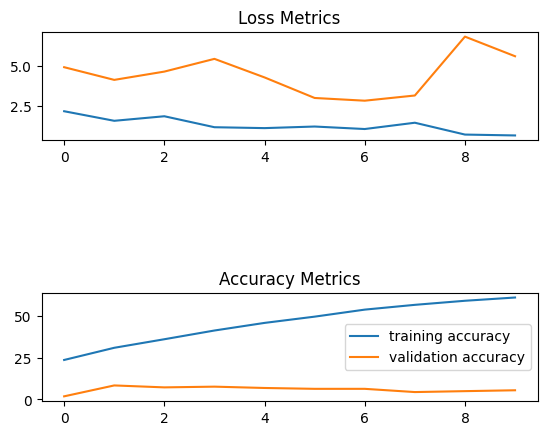

In [ ]:
plt.subplot(3, 1, 1)
plt.plot([loss.detach().numpy() for loss in train_losses], label='training loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='validation loss')
plt.title('Loss Metrics')

plt.subplot(3, 1, 3)
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy Metrics')

plt.legend()

# Applying k-fold cross validation

### Splitting into k-folds and storing

In [ ]:
## creating datasets for k-fold cross validation

import os
import numpy as np
from sklearn.model_selection import KFold
import shutil

base_path = '/content/drive/MyDrive/toybox_sample_resized'

video_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
video_dirs.sort()  # Sort for reproducability

kf = KFold(n_splits=5, shuffle=True, random_state=42)

output_base = '/content/drive/MyDrive/toybox_kfold'
os.makedirs(output_base, exist_ok=True)

for fold, (train_indices, val_indices) in enumerate(kf.split(video_dirs)):
    fold_train_dir = os.path.join(output_base, f'fold_{fold+1}', 'train')
    fold_val_dir = os.path.join(output_base, f'fold_{fold+1}', 'val')
    os.makedirs(fold_train_dir, exist_ok=True)
    os.makedirs(fold_val_dir, exist_ok=True)

    train_dirs = [video_dirs[i] for i in train_indices]
    val_dirs = [video_dirs[i] for i in val_indices]

    for train_dir in train_dirs:
        src = os.path.join(base_path, train_dir)
        dst = os.path.join(fold_train_dir, train_dir)
        shutil.copytree(src, dst)

    for val_dir in val_dirs:
        src = os.path.join(base_path, val_dir)
        dst = os.path.join(fold_val_dir, val_dir)
        shutil.copytree(src, dst)

    print(f'Fold {fold+1}:')
    print(f'Training videos: {len(train_dirs)}, Validation videos: {len(val_dirs)}')

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
from sklearn.model_selection import KFold
import shutil

base_path = '/content/drive/MyDrive/toybox_sample_resized'

video_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
video_dirs.sort()  # Sort for reproducibility

kf = KFold(n_splits=5, shuffle=True, random_state=42)

output_base = '/content/drive/MyDrive/toybox_5fold'
os.makedirs(output_base, exist_ok=True)

label_number_assignment = {}

def extract_label_number(directory_name):
    # Assuming the directory name format is: "label_number" (e.g., "cat_001")
    parts = directory_name.split('_')
    if len(parts) < 2:
        return None, None
    label = parts[0]
    number = parts[1]
    return label, number

for fold, (train_indices, val_indices) in enumerate(kf.split(video_dirs)):
    fold_train_dir = os.path.join(output_base, f'fold_{fold+1}', 'train')
    fold_val_dir = os.path.join(output_base, f'fold_{fold+1}', 'val')
    os.makedirs(fold_train_dir, exist_ok=True)
    os.makedirs(fold_val_dir, exist_ok=True)

    train_dirs = [video_dirs[i] for i in train_indices]
    val_dirs = [video_dirs[i] for i in val_indices]

    for dir_list, split_name in [(train_dirs, 'train'), (val_dirs, 'val')]:
        for current_dir in dir_list:
            label, number = extract_label_number(current_dir)
            if (label, number) not in label_number_assignment:
                label_number_assignment[(label, number)] = (split_name, fold)

            # If already assigned but to a different split, move to the correct split
            elif label_number_assignment[(label, number)][0] != split_name:
                # Find the original split and move the directory
                original_split = label_number_assignment[(label, number)][0]
                original_fold = label_number_assignment[(label, number)][1]
                original_dir = os.path.join(
                    output_base, f'fold_{original_fold+1}', original_split, current_dir
                )
                new_dir = os.path.join(
                    output_base, f'fold_{original_fold+1}', split_name, current_dir
                )
                if os.path.exists(original_dir):
                    shutil.move(original_dir, new_dir)

                label_number_assignment[(label, number)] = (split_name, fold)

            src = os.path.join(base_path, current_dir)
            dst = os.path.join(fold_train_dir if split_name == 'train' else fold_val_dir, current_dir)
            shutil.copytree(src, dst)

    print(f'Fold {fold+1}:')
    print(f'Training videos: {len(train_dirs)}, Validation videos: {len(val_dirs)}')

Fold 1:
Training videos: 74, Validation videos: 19
Fold 2:
Training videos: 74, Validation videos: 19
Fold 3:
Training videos: 74, Validation videos: 19
Fold 4:
Training videos: 75, Validation videos: 18
Fold 5:
Training videos: 75, Validation videos: 18


### Preprocess data

In [ ]:
base_frame_path = '/content/drive/MyDrive/toybox_5fold'

def load_data_for_fold(fold):
    train_list = []
    val_list = []

    fold_train_path = os.path.join(base_frame_path, f'fold_{fold}', 'train')
    fold_val_path = os.path.join(base_frame_path, f'fold_{fold}', 'val')

    directories = [fold_train_path, fold_val_path]
    data_lists = [train_list, val_list]

    unique_labels = set()

    for dataset, data_list in zip(directories, data_lists):
        for class_folder in os.listdir(dataset):
            class_path = os.path.join(dataset, class_folder)

            if os.path.isdir(class_path):
                for frame_file in os.listdir(class_path):
                    if frame_file.endswith('.jpg'):
                        frame_path = os.path.join(class_path, frame_file)
                        label = frame_file.split('_')[0]
                        unique_labels.add(label)
                        image_pil = Image.open(frame_path)
                        image = np.array(image_pil.convert('L')) / 255.0
                        data_list.append((image, label))
                        image_pil.close()

    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    train_list = [(image.flatten(), label_to_index[label]) for image, label in train_list]
    val_list = [(image.flatten(), label_to_index[label]) for image, label in val_list]

    return train_list, val_list

### Training and evaluating each fold

### 1-layer mlp

In [ ]:
# 1-layer mlp

import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

k = 5
batch_size_train = 100
batch_size_val = 500

all_train_losses_1layer = []
all_train_correct_1layer = []
all_val_losses_1layer = []
all_val_correct_1layer = []

# Store labels and predictions
all_train_labels_1layer = []
all_train_predictions_1layer = []
all_val_labels_1layer = []
all_val_predictions_1layer = []

print("Starting k-fold cross validation for 1-layer MLP...")

for fold in range(1, k + 1):
    print(f"Starting fold {fold}...")

    toybox_train, toybox_val = load_data_for_fold(fold)

    train_loader = torch.utils.data.DataLoader(toybox_train, batch_size=batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(toybox_val, batch_size=batch_size_val, shuffle=False)

    toybox_mdl = MLP_1layer()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    toybox_mdl.to(device)

    # Define hyperparameters
    learning_rate = 0.01
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(toybox_mdl.parameters(), lr=learning_rate)

    # Training loop for the current fold
    epochs = 10
    train_losses = []
    train_correct = []
    val_losses = []
    val_correct = []
    start_time = time.time()

    for t in range(epochs):
        train_corr = 0
        val_corr = 0

        # Training phase
        toybox_mdl.train()
        for b, (x_train, y_train) in enumerate(train_loader):
            b += 1
            x_train = x_train.float().to(device)
            y_train = y_train.to(device)

            # Forward pass
            y_pred = toybox_mdl(x_train)
            loss = criterion(y_pred, y_train)

            # Calculate training accuracy
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            train_corr += batch_corr

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            all_train_labels_1layer.extend(y_train.cpu().numpy())
            all_train_predictions_1layer.extend(predicted.cpu().numpy())

        # Record training metrics
        train_losses.append(loss.item())
        train_correct.append(train_corr.item())

        # Validation phase
        toybox_mdl.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for b, (x_val, y_val) in enumerate(val_loader):
                x_val = x_val.float().to(device)
                y_val = y_val.to(device)

                # Forward pass
                y_val_pred = toybox_mdl(x_val)
                val_loss = criterion(y_val_pred, y_val)

                # Calculate validation accuracy
                predicted = torch.max(y_val_pred.data, 1)[1]
                val_corr += (predicted == y_val).sum()

                all_val_labels_1layer.extend(y_val.cpu().numpy())
                all_val_predictions_1layer.extend(predicted.cpu().numpy())

        # Record validation metrics
        val_losses.append(val_loss.item())
        val_correct.append(val_corr.item())

        # Print metrics for each epoch
        print(f"Epoch {t+1}/{epochs}, "
              f"Train Loss: {loss.item():.4f}, Train Acc: {train_corr.item()*100/len(toybox_train):.2f}%, "
              f"Val Loss: {val_loss.item():.4f}, Val Acc: {val_corr.item()*100/len(toybox_val):.2f}%")

    # Record metrics for this fold
    all_train_losses_1layer.append(train_losses)
    all_train_correct_1layer.append(train_correct)
    all_val_losses_1layer.append(val_losses)
    all_val_correct_1layer.append(val_correct)

    print(f"\nFold {fold} Duration: {time.time() - start_time:.0f} seconds")

Starting k-fold cross validation for 1-layer MLP...
Starting fold 1...
Epoch 1/10, Train Loss: 1.9827, Train Acc: 28.38%, Val Loss: 3.2887, Val Acc: 10.19%
Epoch 2/10, Train Loss: 1.5294, Train Acc: 43.17%, Val Loss: 3.2209, Val Acc: 15.32%
Epoch 3/10, Train Loss: 1.2425, Train Acc: 52.18%, Val Loss: 5.2693, Val Acc: 21.42%
Epoch 4/10, Train Loss: 1.1571, Train Acc: 60.61%, Val Loss: 4.2443, Val Acc: 14.10%
Epoch 5/10, Train Loss: 1.3144, Train Acc: 65.98%, Val Loss: 5.6132, Val Acc: 0.06%
Epoch 6/10, Train Loss: 0.9292, Train Acc: 70.35%, Val Loss: 5.9025, Val Acc: 11.57%
Epoch 7/10, Train Loss: 0.6223, Train Acc: 74.09%, Val Loss: 5.9646, Val Acc: 9.51%
Epoch 8/10, Train Loss: 0.6685, Train Acc: 76.69%, Val Loss: 5.5775, Val Acc: 4.87%
Epoch 9/10, Train Loss: 0.9053, Train Acc: 79.49%, Val Loss: 5.2423, Val Acc: 9.28%
Epoch 10/10, Train Loss: 0.4545, Train Acc: 81.25%, Val Loss: 6.1520, Val Acc: 10.71%

Fold 1 Duration: 481 seconds
Starting fold 2...
Epoch 1/10, Train Loss: 1.8165, T

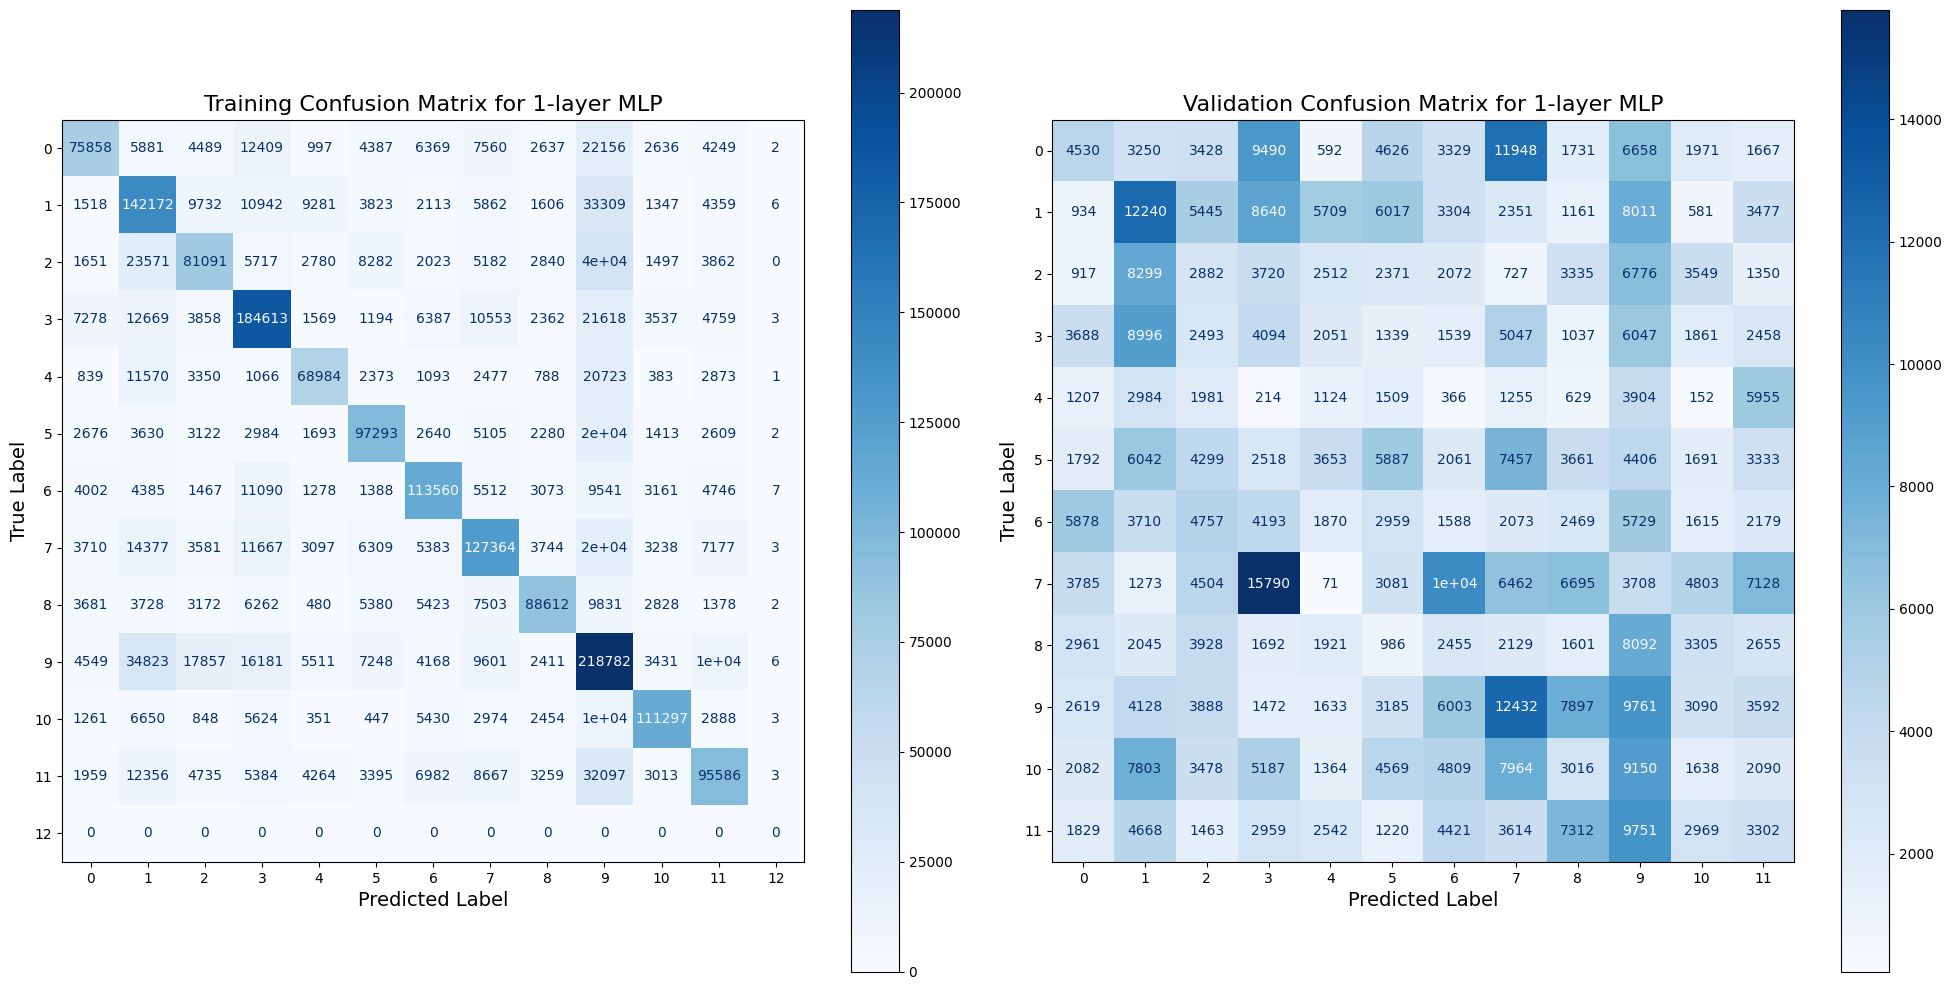

In [ ]:
plot_confusion_matrices(all_train_labels_1layer, all_train_predictions_1layer, all_val_labels_1layer, all_val_predictions_1layer, 1)

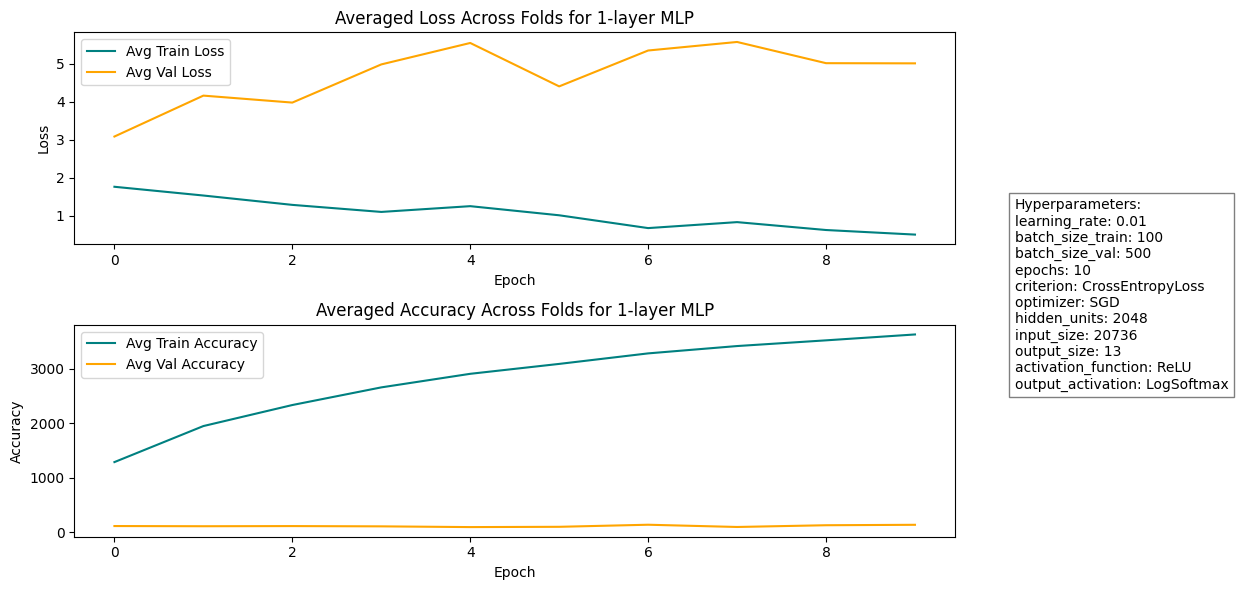

In [ ]:
# Plot average loss and accuracy metrics for 1-layer MLP
hyperparameters = {
    'learning_rate': 0.01,
    'batch_size_train': 100,
    'batch_size_val': 500,
    'epochs': 10,
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'SGD',
    'hidden_units': 2048,
    'input_size': 20736,
    'output_size': 13,
    'activation_function': 'ReLU',
    'output_activation': 'LogSoftmax'
}

plot_average_metrics(all_train_losses_1layer, all_val_losses_1layer, all_train_correct_1layer, all_val_correct_1layer, hyperparameters, num_layers=1)

### 2-layer mlp

In [ ]:
k = 5
batch_size_train = 100
batch_size_val = 500

all_train_losses_2layer = []
all_train_correct_2layer = []
all_val_losses_2layer = []
all_val_correct_2layer = []

# Store labels and predictions
all_train_labels_2layer = []
all_train_predictions_2layer = []
all_val_labels_2layer = []
all_val_predictions_2layer = []

print("Starting k-fold cross validation for 2-layer MLP...")

for fold in range(1, k + 1):
    print(f"Starting fold {fold}...")

    toybox_train, toybox_val = load_data_for_fold(fold)

    train_loader = torch.utils.data.DataLoader(toybox_train, batch_size=batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(toybox_val, batch_size=batch_size_val, shuffle=False)

    toybox_mdl = MLP_2layer()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    toybox_mdl.to(device)

    # Define hyperparameters
    learning_rate = 0.01
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(toybox_mdl.parameters(), lr=learning_rate)

    # Training loop for the current fold
    epochs = 10
    train_losses = []
    train_correct = []
    val_losses = []
    val_correct = []
    start_time = time.time()

    for t in range(epochs):
        train_corr = 0
        val_corr = 0

        # Training phase
        toybox_mdl.train()
        for b, (x_train, y_train) in enumerate(train_loader):
            b += 1
            x_train = x_train.float().to(device)
            y_train = y_train.to(device)

            # Forward pass
            y_pred = toybox_mdl(x_train)
            loss = criterion(y_pred, y_train)

            # Calculate training accuracy
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            train_corr += batch_corr

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            all_train_labels_2layer.extend(y_train.cpu().numpy())
            all_train_predictions_2layer.extend(predicted.cpu().numpy())

        # Record training metrics
        train_losses.append(loss.item())
        train_correct.append(train_corr.item())

        # Validation phase
        toybox_mdl.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for b, (x_val, y_val) in enumerate(val_loader):
                x_val = x_val.float().to(device)
                y_val = y_val.to(device)

                # Forward pass
                y_val_pred = toybox_mdl(x_val)
                val_loss = criterion(y_val_pred, y_val)

                # Calculate validation accuracy
                predicted = torch.max(y_val_pred.data, 1)[1]
                val_corr += (predicted == y_val).sum()

                all_val_labels_2layer.extend(y_val.cpu().numpy())
                all_val_predictions_2layer.extend(predicted.cpu().numpy())

        # Record validation metrics
        val_losses.append(val_loss.item())
        val_correct.append(val_corr.item())

        # Print metrics for each epoch
        print(f"Epoch {t+1}/{epochs}, "
              f"Train Loss: {loss.item():.4f}, Train Acc: {train_corr.item()*100/len(toybox_train):.2f}%, "
              f"Val Loss: {val_loss.item():.4f}, Val Acc: {val_corr.item()*100/len(toybox_val):.2f}%")

    # Record metrics for this fold
    all_train_losses_2layer.append(train_losses)
    all_train_correct_2layer.append(train_correct)
    all_val_losses_2layer.append(val_losses)
    all_val_correct_2layer.append(val_correct)

    print(f"\nFold {fold} Duration: {time.time() - start_time:.0f} seconds")

Starting k-fold cross validation for 2-layer MLP...
Starting fold 1...
Epoch 1/10, Train Loss: 2.1965, Train Acc: 21.51%, Val Loss: 2.5022, Val Acc: 8.69%
Epoch 2/10, Train Loss: 1.7672, Train Acc: 34.99%, Val Loss: 3.4182, Val Acc: 7.12%
Epoch 3/10, Train Loss: 1.5135, Train Acc: 44.93%, Val Loss: 4.3137, Val Acc: 2.70%
Epoch 4/10, Train Loss: 1.4454, Train Acc: 53.05%, Val Loss: 3.4661, Val Acc: 8.75%
Epoch 5/10, Train Loss: 0.7294, Train Acc: 59.88%, Val Loss: 3.9847, Val Acc: 3.13%
Epoch 6/10, Train Loss: 1.4399, Train Acc: 65.61%, Val Loss: 5.4068, Val Acc: 19.61%
Epoch 7/10, Train Loss: 0.5837, Train Acc: 70.71%, Val Loss: 5.3660, Val Acc: 20.23%
Epoch 8/10, Train Loss: 0.5836, Train Acc: 74.25%, Val Loss: 5.9534, Val Acc: 15.35%
Epoch 9/10, Train Loss: 0.4619, Train Acc: 77.57%, Val Loss: 5.3495, Val Acc: 12.81%
Epoch 10/10, Train Loss: 0.6472, Train Acc: 80.21%, Val Loss: 6.0931, Val Acc: 10.90%

Fold 1 Duration: 511 seconds
Starting fold 2...
Epoch 1/10, Train Loss: 2.0598, Tr

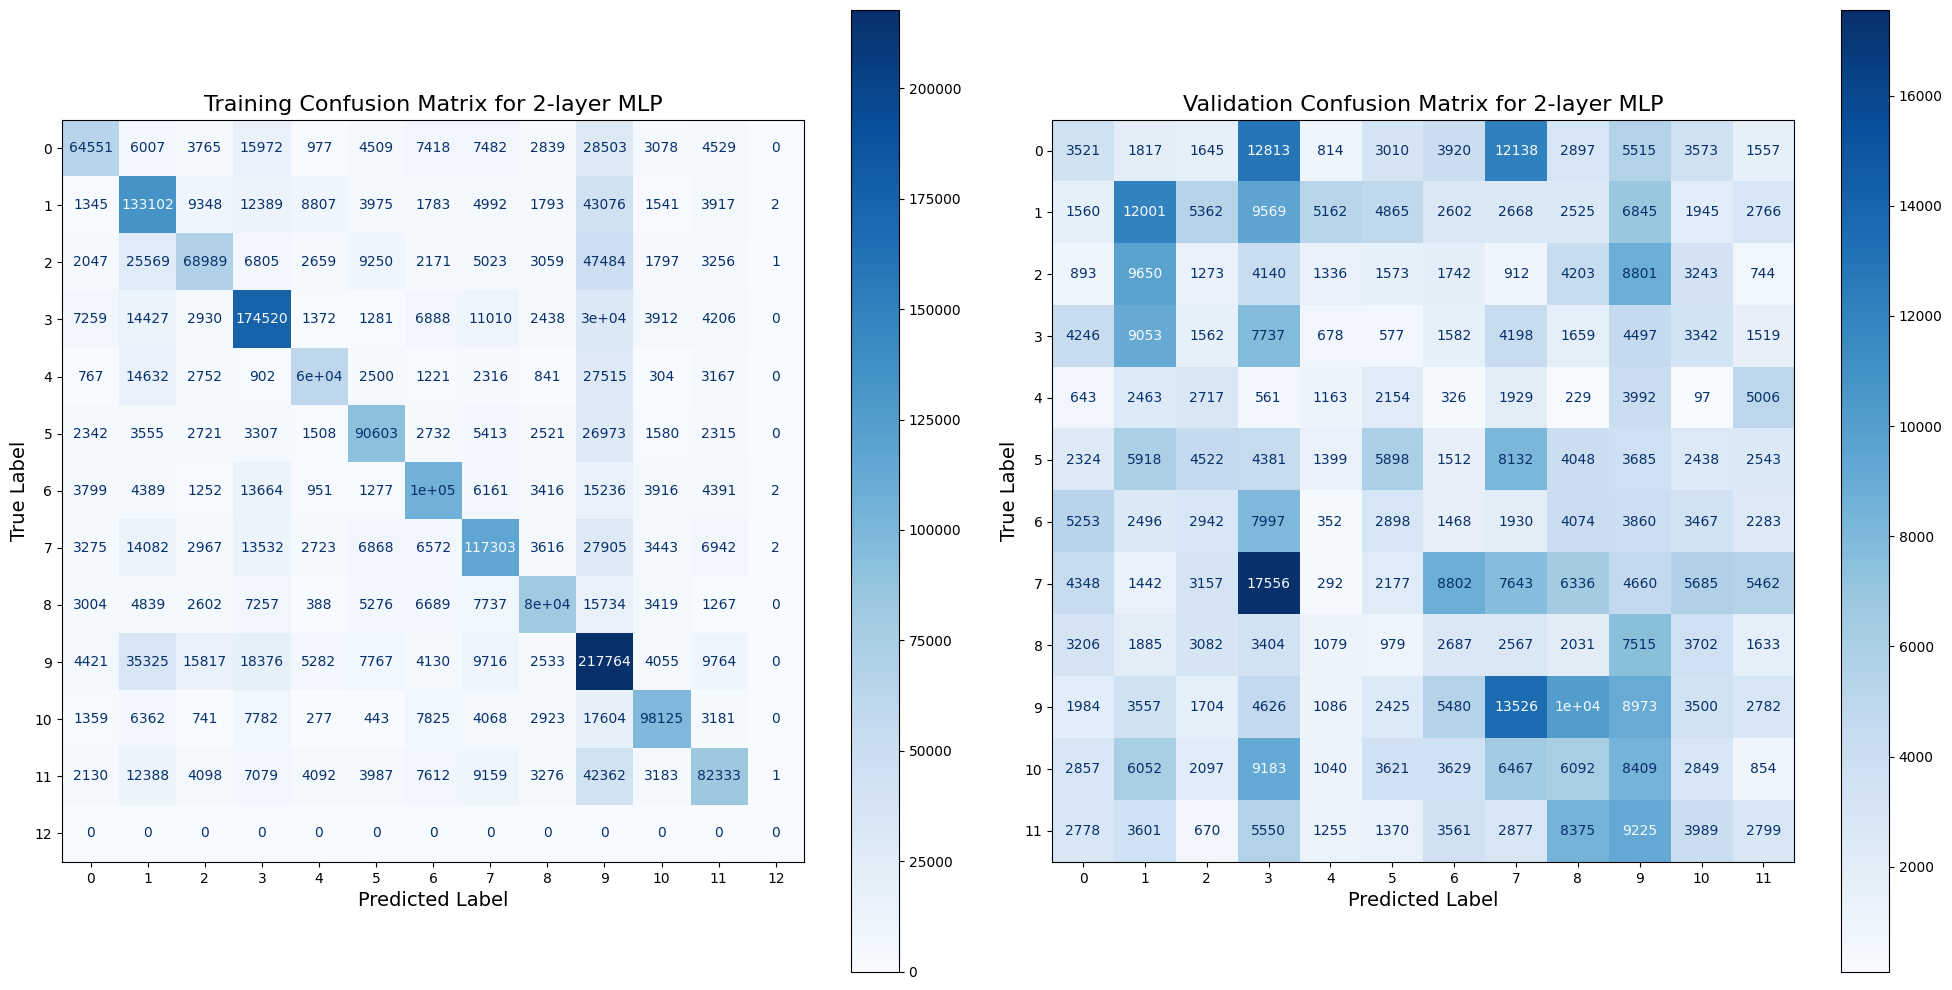

In [ ]:
plot_confusion_matrices(all_train_labels_2layer, all_train_predictions_2layer, all_val_labels_2layer, all_val_predictions_2layer, 2)

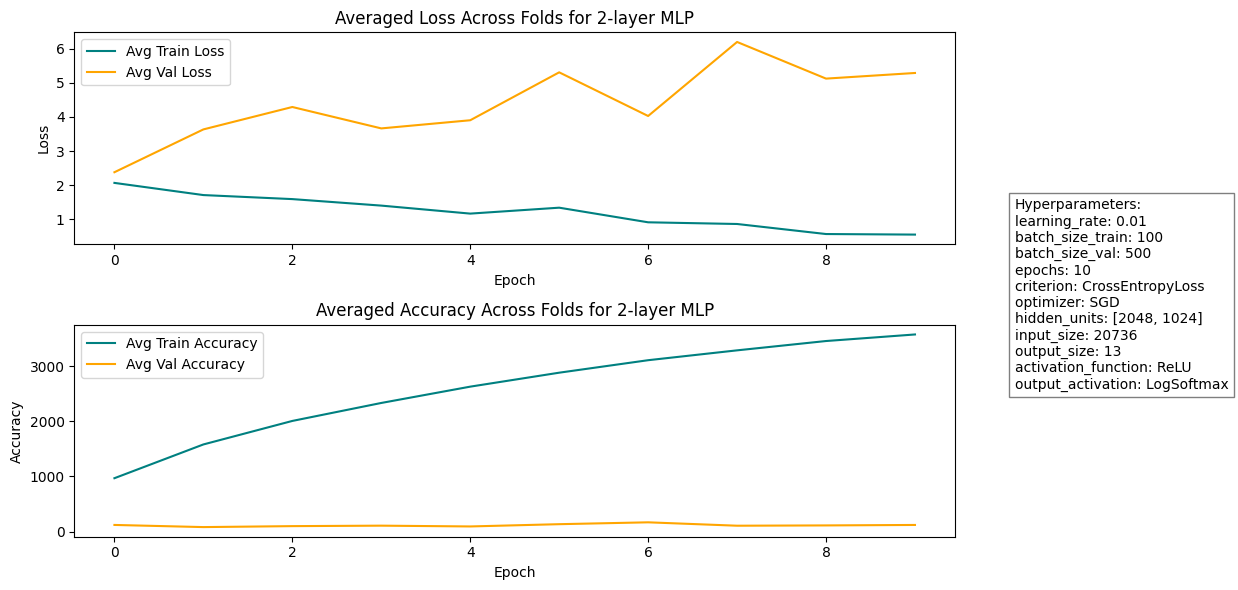

In [ ]:
# Plot average loss and accuracy metrics for 2-layer MLP
hyperparameters = {
    'learning_rate': 0.01,
    'batch_size_train': 100,
    'batch_size_val': 500,
    'epochs': 10,
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'SGD',
    'hidden_units': [2048, 1024],
    'input_size': 20736,
    'output_size': 13,
    'activation_function': 'ReLU',
    'output_activation': 'LogSoftmax'
}

plot_average_metrics(all_train_losses_2layer, all_val_losses_2layer, all_train_correct_2layer, all_val_correct_2layer, hyperparameters, num_layers=2)

### 3-layer MLP

In [ ]:
k = 5
batch_size_train = 100
batch_size_val = 500

all_train_losses_3layer = []
all_train_correct_3layer = []
all_val_losses_3layer = []
all_val_correct_3layer = []

# Store labels and predictions
all_train_labels_3layer = []
all_train_predictions_3layer = []
all_val_labels_3layer = []
all_val_predictions_3layer = []

for fold in range(1, k + 1):
    print(f"Starting fold {fold}...")

    toybox_train, toybox_val = load_data_for_fold(fold)

    train_loader = torch.utils.data.DataLoader(toybox_train, batch_size=batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(toybox_val, batch_size=batch_size_val, shuffle=False)

    toybox_mdl = MLP_3layer()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    toybox_mdl.to(device)

    # Define hyperparameters
    learning_rate = 0.01
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(toybox_mdl.parameters(), lr=learning_rate)

    # Training loop for the current fold
    epochs = 10
    train_losses = []
    train_correct = []
    val_losses = []
    val_correct = []
    start_time = time.time()

    for t in range(epochs):
        train_corr = 0
        val_corr = 0

        # Training phase
        toybox_mdl.train()
        for b, (x_train, y_train) in enumerate(train_loader):
            b += 1
            x_train = x_train.float().to(device)
            y_train = y_train.to(device)

            # Forward pass
            y_pred = toybox_mdl(x_train)
            loss = criterion(y_pred, y_train)

            # Calculate training accuracy
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            train_corr += batch_corr

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            all_train_labels_3layer.extend(y_train.cpu().numpy())
            all_train_predictions_3layer.extend(predicted.cpu().numpy())

        # Record training metrics
        train_losses.append(loss.item())
        train_correct.append(train_corr.item())

        # Validation phase
        toybox_mdl.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for b, (x_val, y_val) in enumerate(val_loader):
                x_val = x_val.float().to(device)
                y_val = y_val.to(device)

                # Forward pass
                y_val_pred = toybox_mdl(x_val)
                val_loss = criterion(y_val_pred, y_val)

                # Calculate validation accuracy
                predicted = torch.max(y_val_pred.data, 1)[1]
                val_corr += (predicted == y_val).sum()

                all_val_labels_3layer.extend(y_val.cpu().numpy())
                all_val_predictions_3layer.extend(predicted.cpu().numpy())

        # Record validation metrics
        val_losses.append(val_loss.item())
        val_correct.append(val_corr.item())

        # Print metrics for each epoch
        print(f"Epoch {t+1}/{epochs}, "
              f"Train Loss: {loss.item():.4f}, Train Acc: {train_corr.item()*100/len(toybox_train):.2f}%, "
              f"Val Loss: {val_loss.item():.4f}, Val Acc: {val_corr.item()*100/len(toybox_val):.2f}%")

    # Record metrics for this fold
    all_train_losses_3layer.append(train_losses)
    all_train_correct_3layer.append(train_correct)
    all_val_losses_3layer.append(val_losses)
    all_val_correct_3layer.append(val_correct)

    print(f"\nFold {fold} Duration: {time.time() - start_time:.0f} seconds")

Starting fold 1...
Epoch 1/10, Train Loss: 2.1543, Train Acc: 16.39%, Val Loss: 2.6704, Val Acc: 13.06%
Epoch 2/10, Train Loss: 2.2426, Train Acc: 23.04%, Val Loss: 4.9188, Val Acc: 0.78%
Epoch 3/10, Train Loss: 2.0085, Train Acc: 30.22%, Val Loss: 4.1027, Val Acc: 2.90%
Epoch 4/10, Train Loss: 1.8955, Train Acc: 39.48%, Val Loss: 4.6792, Val Acc: 10.17%
Epoch 5/10, Train Loss: 1.3653, Train Acc: 46.87%, Val Loss: 4.7150, Val Acc: 22.66%
Epoch 6/10, Train Loss: 1.3472, Train Acc: 53.16%, Val Loss: 5.1418, Val Acc: 22.14%
Epoch 7/10, Train Loss: 1.1374, Train Acc: 59.88%, Val Loss: 3.9884, Val Acc: 21.07%
Epoch 8/10, Train Loss: 0.8413, Train Acc: 65.25%, Val Loss: 5.1915, Val Acc: 14.05%
Epoch 9/10, Train Loss: 0.2902, Train Acc: 69.43%, Val Loss: 4.5161, Val Acc: 9.17%
Epoch 10/10, Train Loss: 0.9848, Train Acc: 73.20%, Val Loss: 5.4195, Val Acc: 4.76%

Fold 1 Duration: 531 seconds
Starting fold 2...
Epoch 1/10, Train Loss: 2.3615, Train Acc: 15.92%, Val Loss: 2.5760, Val Acc: 6.53%
E

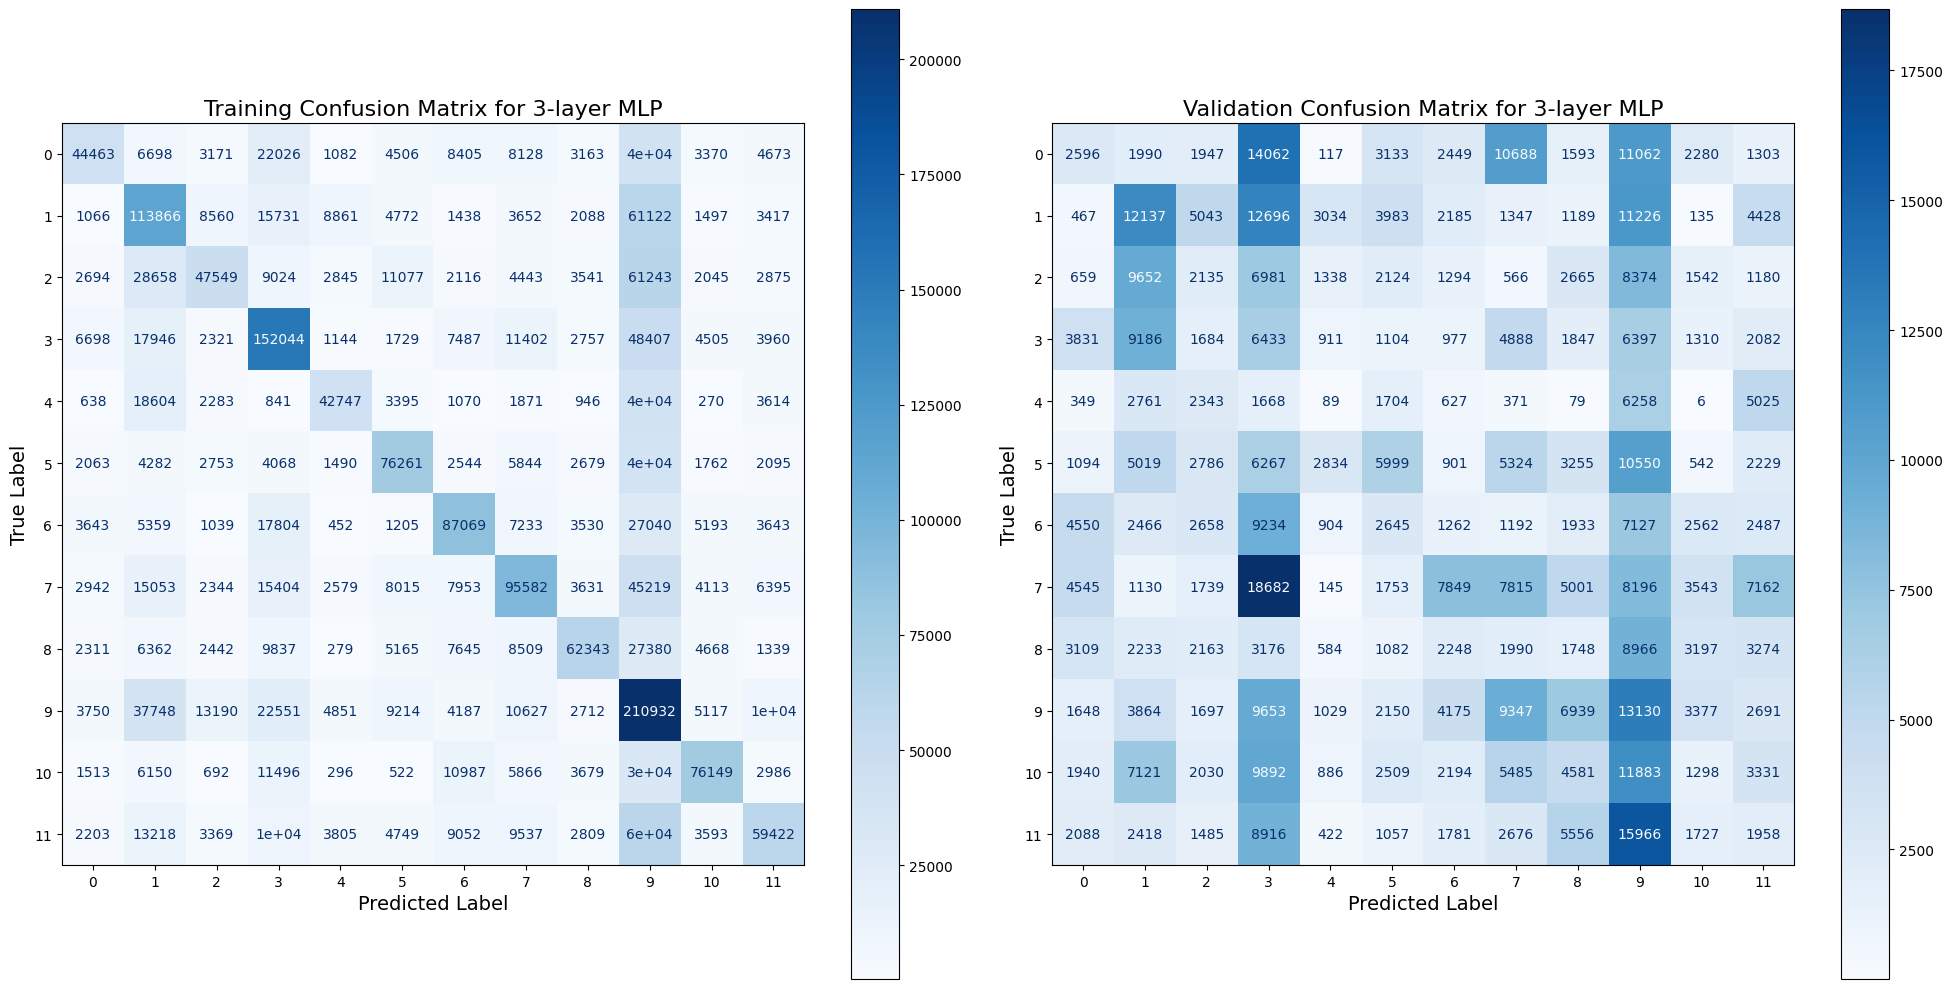

In [ ]:
plot_confusion_matrices(all_train_labels_3layer, all_train_predictions_3layer, all_val_labels_3layer, all_val_predictions_3layer, 3)

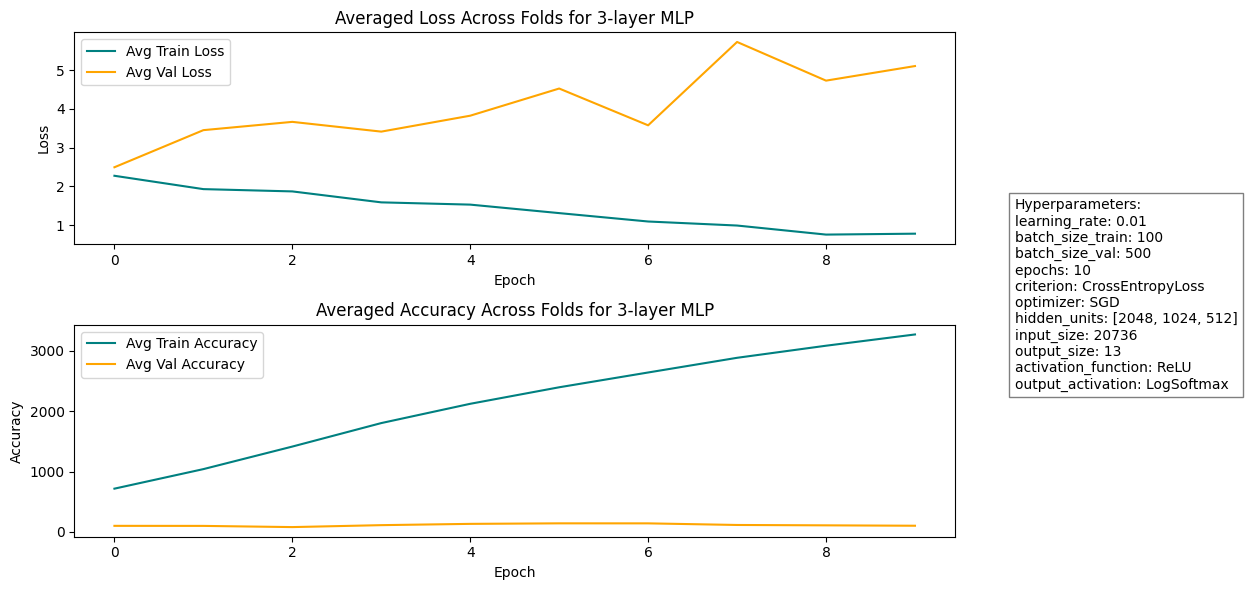

In [ ]:
# Plot average loss and accuracy metrics for 2-layer MLP
hyperparameters = {
    'learning_rate': 0.01,
    'batch_size_train': 100,
    'batch_size_val': 500,
    'epochs': 10,
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'SGD',
    'hidden_units': [2048, 1024, 512],
    'input_size': 20736,
    'output_size': 13,
    'activation_function': 'ReLU',
    'output_activation': 'LogSoftmax'
}

plot_average_metrics(all_train_losses_3layer, all_val_losses_3layer, all_train_correct_3layer, all_val_correct_3layer, hyperparameters, num_layers=3)